<pre><b>Author</b>: Ashlynn Wimer
<b>Date</b>: 3/6/2024
</pre>

Our goal in this notebook is to use the Discourse Atoms method described in Arora et al. (2018) to topic model our data. As we have a word2vec space anyhow, we additionally conduct a tiny word2vec exploration at the end, but we keep it minimal.

In [2]:
import pandas as pd
import numpy as np
import pickle

from ksvd import ApproximateKSVD
import gensim.models
import gensim.similarities
import gensim.utils
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import math

import wordcloud

import lucem_illud
import re

import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import ast

## Making Discourse Atoms

We need to generate a word2vec embedding space to do so. I'm largely interested in the topics _within_ the trans post corpus, so I'm going to limit our word2vec embedding space to that corpus.

... that should also make this file a bit less large, which my laptop appreciates.

In [3]:
def cleaner_tokens(soiled_tokens):
    '''
    Cleans up a few messes in my tokens.

    Inputs:
      soiled_tokens (list of strings): the dirty tokens

    Returns: list of tokens without any punctuation.
    '''
    rv = []
    for value in soiled_tokens:
        if value not in ['<', '+', '>', ':', ';', '=', '/', '\\']:
            value = re.sub(r"[^\w\s']", ' ', value)
            value = re.sub(r"'", '', value)
            value = re.sub(r'\s+', ' ', value).lower()

            rv.append(value)
    return rv

corpus = pd.read_csv('../data/fully_labeled_data.csv', index_col='Unnamed: 0')
corpus = corpus[corpus['transRelated'] == 1]
corpus.head()

,subject,id,author,date,time,content,clean_content,refs,urls,transRelated
8,34548190,34548373,Anonymous,2/5/2024,11:34:50,>>34548225https://twitter.com/hirari12/status/...,\r\nhttps://twitter.com/hirari12/status/173205...,['>>34548225'],['/hirari12/status/1732059315819966769https://...,1
9,34548190,34548423,Anonymous,2/5/2024,11:40:40,">>34548373anon, youre on the tranny board.im a...","\r\nanon, youre on the tranny board.im a thin ...",['>>34548373'],"['', '']",1
11,34548190,34548655,Anonymous,2/5/2024,12:05:38,>>34548423>>34548609i'll have you know i tried...,\r\n\r\ni'll have you know i tried very hard t...,"['>>34548423', '>>34548609']",[],1
13,34548190,34549042,Anonymous,2/5/2024,12:50:45,>>34548423>disgustingly dark penisReminding yo...,\r\n>disgustingly dark penisReminding you why ...,['>>34548423'],[],1
33,34545827,34545945,Anonymous,2/5/2024,5:38:57,">>34545912did i say anything about a ""perfect ...","\r\ndid i say anything about a ""perfect config...",['>>34545912'],[''],1


In [7]:
print('Getting sents..')
corpus['sents'] = corpus['clean_content']\
                            .progress_apply(lambda x: lucem_illud.sent_tokenize(str(x)))

print('Getting tokenized sents...')
corpus['tokenized_sents'] = corpus['sents']\
                            .progress_apply(lambda x: [lucem_illud.word_tokenize(s) for s in x])\
                            .progress_apply(lambda x: [cleaner_tokens(s) for s in x])

print('Normalizing tokens in the sents...')
corpus['normalized_sents'] = corpus['tokenized_sents']\
                            .progress_apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])

print('Saving...')
corpus.to_csv('../data/trans_posts_sents.csv')

corpus[:100:10]


Getting sents..


100%|██████████| 65848/65848 [10:55<00:00, 100.47it/s]


Getting tokenized sents...


100%|██████████| 65848/65848 [00:09<00:00, 7284.04it/s] 


Normalizing tokens in the sents...


  0%|          | 0/65848 [00:00<?, ?it/s]C:\Users\wimer\AppData\Roaming\Python\Python311\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 65848/65848 [07:25<00:00, 147.95it/s]


Saving...


,subject,id,author,date,time,content,clean_content,refs,urls,transRelated,sents,tokenized_sents,normalized_sents
8,34548190,34548373,Anonymous,2/5/2024,11:34:50,>>34548225https://twitter.com/hirari12/status/...,\r\nhttps://twitter.com/hirari12/status/173205...,['>>34548225'],['/hirari12/status/1732059315819966769https://...,1,[https://twitter.com/hirari12/status/173205931...,[[https twitter com hirari12 status 1732059315...,"[[https, twitter, com, hirari12, status, 17320..."
51,34545827,34548837,Anonymous,2/5/2024,12:25:31,>this threadI wonder if ftms are less allergic...,>this threadI wonder if ftms are less allergic...,[],[],1,[>this threadI wonder if ftms are less allergi...,"[[this, threadi, wonder, if, ftms, are, less, ...","[[threadi, wonder, ftms, allergic, plain, nont..."
74,34551118,34551523,Anonymous,2/5/2024,16:20:02,>>34551118Take prog you stupid fuck,\r\nTake prog you stupid fuck,['>>34551118'],[],1,[Take prog you stupid fuck],"[[take, prog, you, stupid, fuck]]","[[prog, stupid, fuck]]"
91,34551607,34551607,Anonymous,2/5/2024,16:27:24,>tfw just got a gf and now ima gonna have to t...,>tfw just got a gf and now ima gonna have to t...,[],[],1,[>tfw just got a gf and now ima gonna have to ...,"[[tfw, just, got, a, gf, and, now, i, m, a, go...","[[tfw, got, gf, m, gon, na, throw, away, troon..."
107,34551482,34551502,Anonymous,2/5/2024,16:18:31,>>34551482If you’re a man you should be the on...,\r\nIf you’re a man you should be the one chas...,['>>34551482'],[],1,[If you’re a man you should be the one chasing...,"[[if, you, re, a, man, you, should, be, the, ...","[[man, chasing], [sub, ftms, hilarious, m, sor..."
119,34551482,34552084,Anonymous,2/5/2024,17:02:10,>>34552056Not true for everyone. I literally j...,\r\nNot true for everyone. I literally just wa...,['>>34552056'],[],1,"[Not true for everyone., I literally just want...","[[not, true, for, everyone], [i, literally, ju...","[[true], [literally, want, autistic, gf]]"
143,34551086,34551100,Anonymous,2/5/2024,15:44:01,>>34551086Icky is fatmaxxing him.,\r\nIcky is fatmaxxing him.,['>>34551086'],[],1,[Icky is fatmaxxing him.],"[[icky, is, fatmaxxing, him]]","[[icky, fatmaxxing]]"
158,34551086,34552715,Anonymous,2/5/2024,17:51:38,>>34551086He's definitely showing signs of hrt,\r\nHe's definitely showing signs of hrt,['>>34551086'],[],1,"[, He's definitely showing signs of hrt]","[[], [he, s, definitely, showing, signs, of, h...","[[], [s, definitely, showing, signs, hrt]]"
193,/hrtgen/ - HRT General - #638 (...),34532326,Anonymous,2/4/2024,5:01:04,"Previous thread: >>34492825• Help, advice, gui...","Previous thread: \r\n• Help, advice, guidance ...",['>>34492825'],"[':', '/xs/s', '/x/s', '/f/s', '/f/s', '/impri...",1,"[Previous thread: \r\n• Help, advice, guidance...","[[previous, thread, help, advice, guidance, on...","[[previous, thread, help, advice, guidance, me..."
206,/hrtgen/ - HRT General - #638 (...),34533910,Anonymous,2/4/2024,9:20:25,">>34533845I do yea, the effects last for a day...","\r\nI do yea, the effects last for a day or tw...",['>>34533845'],[],1,"[, I do yea, the effects last for a day or two...","[[], [i, do, yea, the, effects, last, for, a, ...","[[], [yea, effects, day, basically, makes, tis..."


In [4]:
corpus = pd.read_csv('../data/trans_posts_sents.csv', index_col='Unnamed: 0')
corpus['normalized_sents'] = corpus['normalized_sents'].apply(lambda x: ast.literal_eval(x))

In [4]:
def trim_rule(word, count, min_count):
    '''
    Rule used to trim infrequent words out of our model.
    '''
    if min_count <= count:
        return gensim.utils.RULE_KEEP
    return gensim.utils.RULE_DISCARD

# We identified things that looked like typos earlier, and should have enough
# tokens that we can sacrifice most of the incredibly rare ones (which should
# result in fewer typos and a better model)
# We also use skipgrams here as this runs *shockingly* fast
w2v = gensim.models.word2vec.Word2Vec(corpus['normalized_sents'].sum(), sg=1,
                                             min_count=5, trim_rule=trim_rule)
w2v.save('../data/models/w2v')

In [8]:
w2v.wv.most_similar('trans')

[('insist', 0.6872594952583313),
 ('queer', 0.6652817130088806),
 ('sympathetic', 0.6643879413604736),
 ('theymabs', 0.6639267802238464),
 ('biphobic', 0.6609729528427124),
 ('nbs', 0.6601279377937317),
 ('implied', 0.6551564931869507),
 ('transgirls', 0.6507241129875183),
 ('spicy', 0.6495237350463867),
 ('screech', 0.649350643157959)]

Interesting that "trans" has very few similar words to it in our corpus. How does "tran" fare?

In [9]:
w2v.wv.most_similar('tran')

[('tfem', 0.9485792517662048),
 ('tmasc', 0.9443515539169312),
 ('chadhon', 0.9427003264427185),
 ('weary', 0.9388075470924377),
 ('fujos', 0.9356222748756409),
 ('bratty', 0.9338265061378479),
 ('fujoshi', 0.9338201880455017),
 ('ntr', 0.9330146908760071),
 ('convention', 0.9329088926315308),
 ('fujoshis', 0.9319458603858948)]

In [10]:
w2v.wv.most_similar('puppygirl')

[('stoner', 0.94927978515625),
 ('sea', 0.9459202289581299),
 ('homestuck', 0.9443237781524658),
 ('crusty', 0.9436066150665283),
 ('tmasc', 0.9431067705154419),
 ('fujoshi', 0.9408161044120789),
 ('autogynephile', 0.9384526610374451),
 ('twinkmoder', 0.9358829259872437),
 ('irish', 0.9353550672531128),
 ('lesbo', 0.9341317415237427)]

In [11]:
w2v.wv.most_similar('chaser')

[('sadist', 0.7843812108039856),
 ('cism', 0.7811012268066406),
 ('gayden', 0.7803481817245483),
 ('cisf', 0.7728599905967712),
 ('cisles', 0.7682650089263916),
 ('lesbo', 0.7661051154136658),
 ('tranner', 0.7660885453224182),
 ('enjoyer', 0.7653369307518005),
 ('fujo', 0.7598313689231873),
 ('dom', 0.7591876983642578)]

In [12]:
w2v.wv.most_similar('pooner')

[('dyke', 0.877366304397583),
 ('theyfab', 0.865933895111084),
 ('gayden', 0.8590728640556335),
 ('femcel', 0.844987690448761),
 ('homestuck', 0.8409501314163208),
 ('cisles', 0.8289865255355835),
 ('nonpassing', 0.8276038765907288),
 ('poon', 0.8258849382400513),
 ('cism', 0.8215922713279724),
 ('enjoyer', 0.8215646147727966)]

In [13]:
w2v.wv.most_similar('transmed')

[('refute', 0.9519925713539124),
 ('tucutes', 0.9457590579986572),
 ('preferential', 0.9438371658325195),
 ('soijak', 0.9420627951622009),
 ('st', 0.941486656665802),
 ('favour', 0.9407167434692383),
 ('misunderstand', 0.9403955340385437),
 ('purposefully', 0.9403215646743774),
 ('desistance', 0.9401918053627014),
 ('assertion', 0.938693106174469)]

We now run the Discourse Atoms method. Most of this code is ripped off from the HW4 notebook.

In [14]:
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='../data/models/'):
    ''''''
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros)
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors)

    if save:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20', 'wb')
        pickle.dump(aksvd_t, outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t, outfile)
        outfile.close()

        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t, outfile)
        outfile.close()

    return(dictionary_t, alpha_t)

def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    # reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat)

    squares3= w2vmodel.wv.vectors - np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/

    sst3 = np.sum(np.square(squares3))

    e3 = [reconstructed[i] - w2vmodel.wv.vectors[i] for i in range(0, len(w2vmodel.wv.vectors))]

    sse3 = np.sum(np.square(e3))

    r2 = 1 - (sse3 / sst3)

    rmse = math.sqrt(np.mean(np.square(e3)))

    return(sse3, rmse, r2)

def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords = []

    for i in range(0, len(dictionary_mat)):
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i], topn=top_n)])

    uniquewords = set(topwords)
    diversity = len(uniquewords) / len(topwords)

    return(diversity)

In [15]:
dictionary, alpha = do_aksvd(w2v, 101, 5, save=True)

In [18]:
topic_diversity(w2v, dictionary, top_n=25)

0.8518811881188119

In [17]:
reconst_qual(w2v, dictionary, alpha)

(4063.803479886886, 0.05492454032082159, 0.8961087645141639)

## Exploring Discourse AToms

### First Wave -- Naming

In [5]:
infile = open('../data/models/200d_101comp5nonzeros_dictionary_nvdrsdf20','rb')
dictionary=pickle.load(infile)
infile.close()

infile = open('../data/models/200d_101comp5nonzeros_aksvd_nvdrsdf20','rb')
aksvd=pickle.load(infile)
infile.close()

infile = open('../data/models/200d_101comp5nonzeros_alpha_nvdrsdf20','rb')
alpha=pickle.load(infile)
infile.close()

w2v = gensim.models.Word2Vec.load('../data/models/w2v')

corpus = pd.read_csv('../data/trans_posts_sents.csv', index_col='Unnamed: 0')
corpus['normalized_sents'] = corpus['normalized_sents'].apply(lambda x: ast.literal_eval(x))

In [16]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')

Discourse_Atom 0
['flirted', 'marrying', 'dawn', 'hooking', 'pegged', 'hooked', 'subby', 'untill', 'girli', 'distant', 'accepts', 'malei', 'lover', 'chaste', 'mehow', 'exhausting', 'vag', 'remind', 'grossed', 'disappointing', 'blowjob', 'sadder', 'beats', 'meni', 'daydreaming']


Discourse_Atom 1
['penis', 'vagina', 'hands', 'picture', 'penises', 'image', 'imagine', 'dick', 'word', 'thread', 'argument', 'feet', 'terfs', 'tits', 'ass', 'brains', 'shoulders', 'transphobic', 'community', 'size', 'big', 'cock', 'sense', 'pol', 'bullshit']


Discourse_Atom 2
['excludes', 'disinformation', 'eradicated', 'repressive', 'organisations', 'terrorists', 'arabs', 'ideological', 'intersection', 'labeling', 'globe', 'policies', 'prolific', 'sociology', 'oppressive', 'enforcing', 'footing', 'disastrous', 'civilization', 'eugenics', 'factual', 'perpetrators', 'polygamy', 'extinction', 'mob']


Discourse_Atom 3
['wanna', 'want', 'force', 'allowed', 'wo', 'free', 'wants', 'buy', 'allow', 'let', 'able', '

We're going to attempt to assign posts to anywhere from one to three discourse atoms. 

We create a dictionary of cumulative topic influence, and -- for each word -- add the loadings in each topic for that word to their relevant dictionary entries. We have also tested this by assigning discourse atom membership based on raw counts (i.e. "is this word in the post along this discourse atom at all? then +1 to count") and magnitude of loadings (i.e. track cumulative absolute value of loadings for each word), and our results were robust.   

In [6]:
# Assign discourse atoms to a single set of tokens
def assign_discourse_atoms(tokens, w2v, alpha):

    cnts = {}
    for token in tokens:
        try:
            key_=w2v.wv.key_to_index[token]
        except KeyError:
            continue
        
        # Find discourse atoms with non-zero loading for the token
        for ind in np.where(alpha[key_] != 0)[0]:
            # cnts[ind] = cnts.get(ind, 0) + np.abs(alpha[key_][ind]) # "Add the magnitude of loading"
            # cnts[ind] = cnts.get(ind, 0) + 1 # Track influence of loading, no matter how small.
            cnts[ind] = cnts.get(ind, 0) + alpha[key_][ind] # add the loading itself

    # Get top three most common discourse atoms
    cnts_t = sorted(cnts.items(), key=lambda x: x[1], reverse=True)[:3]

    if cnts_t == []: return [-1, -1, -1]

    cnt_to_beat = .5 * cnts_t[0][1]

    rv = [word if count > cnt_to_beat else -1 
          for word, count in cnts_t]

    return rv

# Flatten a list of lists
# Credit to https://stackoverflow.com/a/17867797
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

# Create a table of discourse atoms three-ples for every post in a corpus 
def assign_discourse_atoms_to_corpus(corpus, w2v, alpha, sents_col='normalized_sents'):
    discourse_atoms = []
    for sent_tokens in corpus[sents_col].tolist():
        tokens = flatten(sent_tokens)
        discourse_atoms.append(assign_discourse_atoms(tokens, w2v, alpha))
    
    return discourse_atoms

In [7]:
discourse_atoms = assign_discourse_atoms_to_corpus(corpus, w2v, alpha)

In [20]:
pd.DataFrame(discourse_atoms, columns=['Topic1 ', 'Topic2', 'Topic3'])

,Topic1,Topic2,Topic3
0,75,-1,-1
1,6,10,15
2,93,12,-1
3,15,-1,-1
4,6,93,-1
...,...,...,...
65843,89,-1,-1
65844,22,-1,-1
65845,71,93,12
65846,8,93,35


In [8]:
corpus_topics = corpus\
    .reset_index()\
    .merge(
        pd.DataFrame(discourse_atoms, 
                        columns=[f'Topic{i+1}' for i, _ in enumerate(discourse_atoms[0])]), 
                        left_index=True, right_index=True
        )\
    .set_index('index')

In [9]:
corpus_topics.head()

,subject,id,author,date,time,content,clean_content,refs,urls,transRelated,sents,tokenized_sents,normalized_sents,Topic1,Topic2,Topic3
index,,,,,,,,,,,,,,,,
8,34548190,34548373,Anonymous,2/5/2024,11:34:50,>>34548225https://twitter.com/hirari12/status/...,\r\nhttps://twitter.com/hirari12/status/173205...,['>>34548225'],['/hirari12/status/1732059315819966769https://...,1,['https://twitter.com/hirari12/status/17320593...,[['https twitter com hirari12 status 173205931...,"[[https, twitter, com, hirari12, status, 17320...",75,-1,-1
9,34548190,34548423,Anonymous,2/5/2024,11:40:40,">>34548373anon, youre on the tranny board.im a...","\r\nanon, youre on the tranny board.im a thin ...",['>>34548373'],"['', '']",1,"[""anon, youre on the tranny board.im a thin 5'...","[['anon', 'you', 're', 'on', 'the', 'tranny', ...","[[anon, tranny, board, m, thin, tranny, cis, l...",6,10,15
11,34548190,34548655,Anonymous,2/5/2024,12:05:38,>>34548423>>34548609i'll have you know i tried...,\r\n\r\ni'll have you know i tried very hard t...,"['>>34548423', '>>34548609']",[],1,"[""i'll have you know i tried very hard to find...","[['i', 'll', 'have', 'you', 'know', 'i', 'trie...","[[ll, know, tried, hard, find, instance, chara...",93,12,-1
13,34548190,34549042,Anonymous,2/5/2024,12:50:45,>>34548423>disgustingly dark penisReminding yo...,\r\n>disgustingly dark penisReminding you why ...,['>>34548423'],[],1,"["">disgustingly dark penisReminding you why yo...","[['disgustingly', 'dark', 'penisreminding', 'y...","[[disgustingly, dark, penisreminding, inferior...",15,-1,-1
33,34545827,34545945,Anonymous,2/5/2024,5:38:57,">>34545912did i say anything about a ""perfect ...","\r\ndid i say anything about a ""perfect config...",['>>34545912'],[''],1,"['did i say anything about a ""perfect configur...","[['did', 'i', 'say', 'anything', 'about', 'a',...","[[perfect, configuration, retard], [s, literal...",6,93,-1


I want to find what documents are "closest" to each topic, so I can better understand my topics. To do so, I'm going to create document vectors by summing up the vectors of each word in every document. I can then compare the (cosine) distance of each document vector to each topic, and pick the closest documents as representatives. While I could likely have an easier time with the actual programming aspect of this by simply picking using a doc2vec model -- KSVD should work on that -- the last time I made such a model at the post level I did it for just the week1 data, and the resultant docspace was 13 GB large, which is a bit more than my computer can wrangle.

Once I do that, I'll save the associations and go through a fun labeling exercise. Yipee!

Now that we have our documents assigned and topics named, let's check the distribution of topics globally, and whether tripcodes have any influence on topics.

In [10]:
# Flatten a list of lists
# Credit to https://stackoverflow.com/a/17867797
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

def create_doc_vec(tokenized_sents, w2v, normalized=False):
    '''
    Takes in tokenized sentences in a document, returns its (possibly normalized) location in
    space.
    '''
    tokens = flatten(tokenized_sents)

    # if it's empty, it's just at 0 lol.
    if tokens == []: return [0 for i in range(len(w2v.wv['catgirl']))]

    # Stubbornly attempt to set the docvec
    docvec = None
    while docvec is None:
        try:
            docvec = w2v.wv[tokens.pop(0)].copy()
        except KeyError:
            continue
        except IndexError:
            return [0 for i in range(len(w2v.wv['catgirl']))]

    for token in tokens:
        try:
            docvec += w2v.wv[token]
        except KeyError:
            continue
    
    if normalized: return docvec / np.linalg.norm(docvec)

    return docvec


corpus['docvecs'] = corpus['normalized_sents'].apply(lambda x: create_doc_vec(x, w2v, True))

corpus.head()

,subject,id,author,date,time,content,clean_content,refs,urls,transRelated,sents,tokenized_sents,normalized_sents,docvecs
8,34548190,34548373,Anonymous,2/5/2024,11:34:50,>>34548225https://twitter.com/hirari12/status/...,\r\nhttps://twitter.com/hirari12/status/173205...,['>>34548225'],['/hirari12/status/1732059315819966769https://...,1,['https://twitter.com/hirari12/status/17320593...,[['https twitter com hirari12 status 173205931...,"[[https, twitter, com, hirari12, status, 17320...","[-0.017068788, 0.05159369, 0.043751344, -0.044..."
9,34548190,34548423,Anonymous,2/5/2024,11:40:40,">>34548373anon, youre on the tranny board.im a...","\r\nanon, youre on the tranny board.im a thin ...",['>>34548373'],"['', '']",1,"[""anon, youre on the tranny board.im a thin 5'...","[['anon', 'you', 're', 'on', 'the', 'tranny', ...","[[anon, tranny, board, m, thin, tranny, cis, l...","[-0.08322721, 0.12063161, 0.021284165, -0.0373..."
11,34548190,34548655,Anonymous,2/5/2024,12:05:38,>>34548423>>34548609i'll have you know i tried...,\r\n\r\ni'll have you know i tried very hard t...,"['>>34548423', '>>34548609']",[],1,"[""i'll have you know i tried very hard to find...","[['i', 'll', 'have', 'you', 'know', 'i', 'trie...","[[ll, know, tried, hard, find, instance, chara...","[-0.06804655, 0.08300253, 0.0042559993, 0.0458..."
13,34548190,34549042,Anonymous,2/5/2024,12:50:45,>>34548423>disgustingly dark penisReminding yo...,\r\n>disgustingly dark penisReminding you why ...,['>>34548423'],[],1,"["">disgustingly dark penisReminding you why yo...","[['disgustingly', 'dark', 'penisreminding', 'y...","[[disgustingly, dark, penisreminding, inferior...","[-0.039958205, 0.1160124, 0.0059620575, -0.075..."
33,34545827,34545945,Anonymous,2/5/2024,5:38:57,">>34545912did i say anything about a ""perfect ...","\r\ndid i say anything about a ""perfect config...",['>>34545912'],[''],1,"['did i say anything about a ""perfect configur...","[['did', 'i', 'say', 'anything', 'about', 'a',...","[[perfect, configuration, retard], [s, literal...","[-0.104342535, 0.03544623, -0.048177004, -0.00..."


In [21]:
#corpus_topics = corpus_topics.reset_index()

has_non_anon_author = corpus_topics['author'] != 'Anonymous'

corpus_topics[has_non_anon_author].shape

(6288, 16)

In [22]:
def count_topics(corpus_topics):
    counts = {}
    for ind, row in corpus_topics.iterrows():
        counts[row['Topic1']] = counts.get(row['Topic1'], 0) + 1
        
        if row['Topic2'] != -1: counts[row['Topic2']] = counts.get(row['Topic2'], 0) + 1
        if row['Topic3'] != -1: counts[row['Topic3']] = counts.get(row['Topic3'], 0) + 1
    return counts

Lets get five posts per topic. 

In [9]:
def find_n_closest_docs(dictionary, docs, n):
    topics = np.array(dictionary)
    docvecs = np.array(docs['docvecs'].tolist())

    # Find our cosine similarity on the big set _first_
    similarity_matrix = cosine_similarity(topics, docvecs)

    top_n_indices = np.argsort(-similarity_matrix, axis=1)[:, :n]

    return top_n_indices

exemplar_posts = find_n_closest_docs(dictionary, corpus, 5)

In [30]:
import pprint

corpus_reset = corpus.reset_index()
labels = [None for i in range(len(dictionary))]
i = 0
while i < len(dictionary):
    
    # Print relevant info for labeling
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    for num, j in enumerate(exemplar_posts[i]):
        pprint.pprint(f'Exemplar {num}: '  + corpus_reset['content'].values[j]) # what is the most similar document to this atom?

    # Request a label
    label = input('What would you call this category?')

    # So I can relabel things if/when the raw_input request breaks somehow
    if label == 'back':
        i-=1
        print('Going back one..')
        print('---------------------\n')
        continue
    
    labels[i] = label
    i+=1

    print('=============================\n')

Discourse_Atom 0
['flirted', 'marrying', 'dawn', 'hooking', 'pegged', 'hooked', 'subby', 'untill', 'girli', 'distant', 'accepts', 'malei', 'lover', 'chaste', 'mehow', 'exhausting', 'vag', 'remind', 'grossed', 'disappointing', 'blowjob', 'sadder', 'beats', 'meni', 'daydreaming']
("Exemplar 0: >tfw your boyfriend of one year tells you that he's transphobic, "
 'never loved you, and just dated you because he hates trannies and wanted to '
 'play around with the feelings of one (by dating one for a while before '
 "revealing that it was all just a prank and that he'd always hated them/found "
 'them disgusting)')
('Exemplar 1: >>34807538yea she is a tranny, for longer than me, she probably '
 'thought i was always pathetic since we met in 2015i got raped and she knew '
 'it, back in 2017we met on grindr again about a year ago until i agree to '
 'meet again thinking she really wanted to be my friend, but she was just '
 'horny for me and was kinda really rough but not rapey, after "hooking


Discourse_Atom 1
['penis', 'vagina', 'hands', 'picture', 'penises', 'image', 'imagine', 'dick', 'word', 'thread', 'argument', 'feet', 'terfs', 'tits', 'ass', 'brains', 'shoulders', 'transphobic', 'community', 'size', 'big', 'cock', 'sense', 'pol', 'bullshit']
'Exemplar 0: >>34812609Penis'
'Exemplar 1: >>34759233Does it have a penis or a vagina?'
('Exemplar 2: >>34774885please tell me it was penis in vagina. penis in '
 'vagina. vhpenis in vagina. hdspenis in vagina. dhhjpenis in vagina. sdgpenis '
 'in vagina. vpenis in vagina.fhpenis in vagina......penis in vagina. penis in '
 'vagina....penis in vagina. penis in vagina..penis in vagina!!!!!!')
'Exemplar 3: >>34817586Only if he has a vagina'
'Exemplar 4: >>34687232>penis envydamn it Freud'

Discourse_Atom 2
['excludes', 'disinformation', 'eradicated', 'repressive', 'organisations', 'terrorists', 'arabs', 'ideological', 'intersection', 'labeling', 'globe', 'policies', 'prolific', 'sociology', 'oppressive', 'enforcing', 'footing', 'dis

Due to fear and terror, we now save the names:

In [31]:
# with open('../data/labels.csv', 'w') as f:
#     for ind, label in enumerate(labels):
#         f.write(f"{ind}, '{label}'\n")

and reload them:

In [11]:
#loading back the model pieces, albeit in a slightly messier format
labels = []
with open('../data/labels.csv') as f:
    labels = f.readlines()
labels[:5]

["0, 'relationship discussion'\n",
 "1, 'genetalia discussion'\n",
 "2, 'political discussion'\n",
 "3, 'wanting, forcing, making, letting'\n",
 "4, 'HRT and hormone blockers discussion'\n"]

### Second Wave - Refinement

With the names saved, let's take a deeper look at our discourse atoms. 

Based on the naming phase, we have three categories we want to investigate for coherence.

1. Social Transition Machinery related topics.
2. "Other Media" related topics (i.e. topics which indicate the usage of other social media alongside /lgbt/)
3. Toxicity (trolling, fetishization, etc)

We start with Social Transition Machinery related topics, and have three potential "sub-categories" our suspects may fall into:

1. Concrete transition advice (HRT, passing, etc)
2. Identity construction work (discussion of what transness is)
3. Mental support discussion

We do close reading of the top 25 posts for the potentially relevant topics to better group them. For each topic, we will either place them into one of the three above groups, or remove them from the list.

In [10]:
suspects = [4, 5, 16, 19, 21, 23, 27, 43, 44, 46, 48, 52, 54, 57, 62, 68, 75, 76, 83, 84, 89, 93, 99]

exemplar_posts = find_n_closest_docs(dictionary, corpus, 25)

In [24]:
import pprint

for suspect in suspects:
    print(f'====== Topic {suspect} ======')
    pprint.pprint(corpus.reset_index()['content'].values[exemplar_posts[suspect]].tolist())
    print('=======')
    input('press 0 when ready')

====== Topic 43 ======
['>>34790799womanhood is not defined by misogyny, womanhood is not suffering',
 '>>34589277Not me, I have transcended womanhood.',
 ">>34766354if you don't control for sexual orientation, that correlation is "
 'meaningless.',
 '>>34562256no, sexual orientation is genetic and fixed at birth',
 ">>34816994They think it's purely a social contagion and not something caused "
 'by biological factors.']


====== Topic 62 ======
[">>34598507it's almost like you're an AGP and your paraphilia was developed "
 "by porn addiction>>34598533it's almost like you're an AGP and your "
 "paraphilia was developed by porn addiction>>34598557it's almost like you're "
 "an AGP and your paraphilia was developed by porn addiction>>34604554it's "
 "almost like you're an AGP and your paraphilia was developed by porn "
 "addiction>>34604595it's almost like you're an AGP and your paraphilia was "
 'developed by porn addiction',
 '>>34614984Classic meta-attracted AGP behaviour',
 '>>34587324Coping with the fact that AGP is a sexual orientation that some '
 'tranners can have and that makes you upset, its not about just feeling '
 "sexy/desirable/good in your body see >>34586460 again, and the AGP's who are "
 'into TG, or see /GYWB/ on /trash/ for examples>what makes you think that '
 "isn't just the dysphoria coming and going your sexual orientation responding "
 "to that, or the dreaded bi-cycle?Cause I do

We need to do a little bit of additional clarification on a few categories:

In [25]:
import pprint
suspects = [43, 62, 76, 83, 57, 27]
exemplar_posts = find_n_closest_docs(dictionary, corpus, 25)
for suspect in suspects:
    print(f'====== Topic {suspect} ======')
    pprint.pprint(corpus.reset_index()['content'].values[exemplar_posts[suspect]].tolist())
    print('=======')
    input('press 0 when ready')

====== Topic 43 ======
['>>34790799womanhood is not defined by misogyny, womanhood is not suffering',
 '>>34589277Not me, I have transcended womanhood.',
 ">>34766354if you don't control for sexual orientation, that correlation is "
 'meaningless.',
 '>>34562256no, sexual orientation is genetic and fixed at birth',
 ">>34816994They think it's purely a social contagion and not something caused "
 'by biological factors.',
 '>>34763578a cure implies a diseaseand my identity is not a disease',
 '>>34583854>fetishes develop from repressed psychological materialmost '
 "trannies didn't get to really experience childhood or emotional development "
 'wholly or as themselves, or at all',
 '>>34621739well some innate talent is important too',
 '>>34596217Trauma.',
 '>>34824925Very extreme cases of intersex condition for some, fetishes for '
 'others.',
 '>>34587030you have your own sexuality and the rest is cope, if it hinges on '
 "you having feminine traits that doesn't it make it a sexual or

Based on the reading, we have _two_ subcategories instead of three, and some new topic names:

**Concrete Transition Support and Discussion:**

* Topic 04 - HRT, Hormone Discussion and Advice
* Topic 23 - DIY HRT supplier links
* Topic 48 - HRT Discussion, Stoires, Advice
* Topic 52 - HRT Dosage Disucssion
* Topic 05 - Fat Redistribution, Exercise
* Topic 19 - FFS, Passing experiences, Plans/Venting
* Topic 44 - Voice training, joking passing advice
* Topic 54 - Voice Training Advice and Feedback

**Identity:**

* Topic 43 - Womanhood, Transness, Mental Illness, Clarifications
* Topic 62 - Interplay of AGP and Identity
* Topic 73 - Transness and Neurology
* Topic 83 - Nature of Gender + Sexuality

We also found three topics that seem like potential contendors for the toxicity category:
* Topic 46 - t4t, c4t, st4t insults and gatekeeping
* Topic 57 - quiddity of sex, biology debates
* Topic 93 - debates over whether transness is real
* Topic 99 - Brain damage / fetish accusations


We now investigate topics which might be related to toxicity.

In [28]:
suspects = [46, 57, 93, 99, 25, 42, 53, 56, 6, 38, 97, 91]

for suspect in suspects:
    print(f'====== Topic {suspect} ======')
    pprint.pprint(corpus.reset_index()['content'].values[exemplar_posts[suspect]].tolist())
    print('=======')
    input(f'press 0 when ready, displaying topic {suspect}')

====== Topic 46 ======
['>>34627897same>t4t',
 '>>34790502some people say he posted his T vial on st4t',
 '>>34810575Please don’t he/him me I told you I don’t like it',
 '>>34567674No you can’t make me!',
 '>>34607252No they don’t do that.',
 '>>348123596” isn’t enough for any bottom',
 '>>34590717>Don’t call me “they”',
 '>>34623185There can’t be an in-between?',
 '>>34537674Don’t do it',
 't4t kafwolf > c4t kafstel',
 '>>34558551T>>34558562T>>34558607T>>34558624T>>34558638G>>34558645L>>34558711T>>34558730T>>34558962T>>34558967T>>34559040T>>34559054T>>34559136T>>34559758L>>34559845T>>34560236T>>34560584G>>34560726G>>34560730T>>34560913T>>34562410T>>34563553L>>34564107T>>34564655L>>34564948T>>34565063T>>34565143B>>34565334T>>34565485T>>34565619L>>34567417B>>34569577T>>34569627B>>34569710G>>34569857G>>34570129T>>34570692B>>34571152B>>34571243G>>34571323L>>34571368T',
 '>>34779713>it can’t be true it can’t it can’t',
 '>>34737423This is mostly T4T and mostly lesbian T4T. Mostly.',
 'You 

We find that the following topics fall into the growing toxicity category: 
46, 57, 93, 99, and 42

With the names saved, we can immediately discuss a hypothesis. In particular:

> If 4chan is a care structure, we expect multiple topics that are relate to concrete traces of trans life (e.g. HRT, advice on passing, etc).


This hypothesis seems to be the case -- 4chan has _multiple_ topics which are related to navigating concrete traces of trans life. In particular, the following topics below:

In [33]:
concrete_traces_topics = [0, 16, 81, 65, 74]

for i in concrete_traces_topics:
    print("Discourse_Atom " + str(i) + f' dubbed {labels[i]}')
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    for num, j in enumerate(exemplar_posts[i]):
        print(f'Examplar {num}:')
        pprint.pprint(corpus_reset['content'].values[j]) # what is the most similar document to this atom?
    print('==============================\n')

Discourse_Atom 0 dubbed relationship discussion
['flirted', 'marrying', 'dawn', 'hooking', 'pegged', 'hooked', 'subby', 'untill', 'girli', 'distant', 'accepts', 'malei', 'lover', 'chaste', 'mehow', 'exhausting', 'vag', 'remind', 'grossed', 'disappointing', 'blowjob', 'sadder', 'beats', 'meni', 'daydreaming']
Examplar 0:
(">tfw your boyfriend of one year tells you that he's transphobic, never loved "
 'you, and just dated you because he hates trannies and wanted to play around '
 'with the feelings of one (by dating one for a while before revealing that it '
 "was all just a prank and that he'd always hated them/found them disgusting)")
Examplar 1:
('>>34807538yea she is a tranny, for longer than me, she probably thought i '
 'was always pathetic since we met in 2015i got raped and she knew it, back in '
 '2017we met on grindr again about a year ago until i agree to meet again '
 'thinking she really wanted to be my friend, but she was just horny for me '
 'and was kinda really rough bu

In [50]:
media_topics = [35, 50, 90]

for i in media_topics:
    print("Discourse_Atom " + str(i) + f' dubbed {labels[i]}')
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    for num, j in enumerate(exemplar_posts[i]):
        print(f'Examplar {num}:')
        pprint.pprint(corpus['content'].values[j]) # what is the most similar document to this atom?
    print('==============================\n')

Discourse_Atom 35 dubbed 35, 'social media feature discussion, picrew, discord'

['picrew', 'deleted', 'reply', 'frengen', 'replies', 'text', 'server', 'gif', 'hi', 'images', 'screenshot', 'coal', 'hey', 'trips', 'ftmg', 'archived', 'folder', 'replying', 'discords', 'gg', 'bump', 'fr', 'hello', 'fren', 'ty']
Examplar 0:
'>>34614118 server link?'
Examplar 1:
'>>34769634>>34771473oops forgot to reply'
Examplar 2:
'>>34592531hi card'
Examplar 3:
'>>34743926hey kayla, trip off dunderhead'
Examplar 4:
'>>34781298@cl1nton_ on discord btw'
Examplar 5:
'>>34608380Hey discord?'
Examplar 6:
'>>34555695hi hello'
Examplar 7:
'>>34791033Hey Kim'
Examplar 8:
'>>34574799hey op what manga is this screencap from'
Examplar 9:
'>>34545460Add this cutie, her trip code was XXXXXX or smth'
Examplar 10:
'>>34791033hi Kim'
Examplar 11:
'Anyone here wanna check out my cool thread and post in it? :3 >>34728778'
Examplar 12:
'>>34815385hi maiq!!!'
Examplar 13:
('>>34687065Btw OP here, if anyone wants to chat you

Based on the above, topics 35 and 50 do consist of many links to other social media, but also to other threads on /lgbt/.

## Trend Verification

We first use PMI to create lists of distinctive words which should let us verify that the social transition machinery discourse atoms are as such.

In [54]:
HRT_TOPICS = [4, 23, 48, 52]
VT_TOPICS = [44, 54]
BODY_TOPICS = [19, 5]
TRANSITION_UNDERSTANDING = [43, 83, 62]
BIOLOGY_UNDERSTANDING = [76, 27, 57]
STM_TOPICS = HRT_TOPICS + VT_TOPICS + BODY_TOPICS + TRANSITION_UNDERSTANDING + BIOLOGY_UNDERSTANDING

TROLLING = [99, 6]
FETISH = [42]
HATE_POST_TOPICS = TROLLING + FETISH

counts = {
    'HRT':0,
    'VT':0,
    'BODY':0,
    'TRANS_UNDR':0,
    'BIOL_UNDR':0,
    'STM':0,
    'TROLL':0,
    'FETISH':0
}

for i, post in corpus_topics.iterrows():
    post_topic = post['Topic1']
    
    if post_topic in HRT_TOPICS:
        counts['HRT'] += 1
        counts['STM'] += 1
    elif post_topic in VT_TOPICS:
        counts['VT'] += 1
        counts['STM'] += 1
    elif post_topic in BODY_TOPICS:
        counts['BODY'] += 1
        counts['STM'] += 1
    elif post_topic in TRANSITION_UNDERSTANDING:
        counts['TRANS_UNDR'] += 1
        counts['STM'] += 1
    elif post_topic in BIOLOGY_UNDERSTANDING:
        counts['BIOL_UNDR'] += 1
        counts['STM'] += 1
    elif post_topic in TROLLING:
        counts['TROLL'] += 1
    elif post_topic in FETISH:
        counts['FETISH'] += 1


normed_counts = {
    (topic, 100 * count / len(corpus_topics)) for topic, count in counts.items()
}

normed_counts, counts

({('BIOL_UNDR', 0.49811687522779735),
  ('BODY', 3.852812537966225),
  ('FETISH', 0.02733568217713522),
  ('HRT', 3.5688251731259872),
  ('STM', 11.128659944113716),
  ('TRANS_UNDR', 2.5012149192078725),
  ('TROLL', 9.395881423885312),
  ('VT', 0.707690438585834)},
 {'HRT': 2350,
  'VT': 466,
  'BODY': 2537,
  'TRANS_UNDR': 1647,
  'BIOL_UNDR': 328,
  'STM': 7328,
  'TROLL': 6187,
  'FETISH': 18})

In [29]:
# Minimum number of appearances a token needs to make in all three of our subsets to be considered.
MINIMUM_APPEARANCES = 20

token_post_global = {}
token_post_stm = {}
token_post_transition = {}
token_post_biology = {}
token_post_body = {}
token_post_vt = {}
token_post_hrt = {}

token_prob = {}

import math
# We start by finding the probabilities that tokens appear in any given post

def update_token_dicts(dicts: list, tokens: list):
    '''
    Updates every token counting dictionary in a list of dictionaries with the
    knowledge of the new tokens
    '''
    for token in set(tokens):
        if token == '': continue
        for d in dicts:
            d[token] = d.get(token, 0) + 1

def tokenize(content: str) -> list:
    '''
    Given the content of a post, turn it into a clean list of tokens.
    '''
    tokenized = re.sub(r"[^\w\s']", ' ', str(content))
    tokenized = re.sub(r"'", '', tokenized)
    tokenized = re.sub(r'\s+', ' ', tokenized).lower()
    tokenized = tokenized.split(' ')

    return tokenized    

# Count num posts each token appears in for our entire corpus
for i, post in corpus_topics.iterrows():
    
    # tokenize the post
    tokenized = tokenize(post['clean_content'])
    post_topic = post['Topic1']

    # it is marginally faster to ask the ifs on the outside
    if post_topic in HRT_TOPICS:
        update_token_dicts([token_post_global, token_post_stm, token_post_hrt], tokenized)
    elif post_topic in VT_TOPICS:
        update_token_dicts([token_post_global, token_post_stm, token_post_vt], tokenized)
    elif post_topic in BODY_TOPICS:
        update_token_dicts([token_post_global, token_post_stm, token_post_body], tokenized)
    elif post_topic in TRANSITION_UNDERSTANDING:
        update_token_dicts([token_post_global, token_post_stm, token_post_biology], tokenized)
    elif post_topic in BIOLOGY_UNDERSTANDING:
        update_token_dicts([token_post_global, token_post_stm, token_post_transition], tokenized)
    else:
        update_token_dicts([token_post_global], tokenized)

# Convert to probabilities
# We use a laplace smoothing with alpha=1.
for token in token_post_global.keys():

    # enforce commonness
    if token_post_global.get(token, 0) < MINIMUM_APPEARANCES: continue

    # Global prob
    global_prob = token_post_global.get(token, 1)       / len(corpus)
    hrt_prob    = token_post_hrt.get(token, 1)          / len(corpus)
    stm_prob    = token_post_stm.get(token, 1)          / len(corpus)
    vt_prob     = token_post_vt.get(token, 1)           / len(corpus)
    body_prob   = token_post_body.get(token, 1)         / len(corpus)
    trans_prob  = token_post_biology.get(token, 1)      / len(corpus)
    bio_prob    = token_post_transition.get(token, 1)   / len(corpus)

    token_prob[token] = {'global': global_prob, 
                         'stm':stm_prob, 
                         'hrt': hrt_prob, 
                         'vt': vt_prob, 
                         'body': body_prob,
                         'phils': trans_prob,
                         'science': bio_prob}


In [30]:
# Calculate PMIs
stm_pmis        = {}
biology_pmis    = {}
transition_pmis = {}
body_pmis       = {}
vt_pmis         = {}
hrt_pmis        = {}

prob_post_scprs   = sum(corpus_topics['Topic1'].isin(BIOLOGY_UNDERSTANDING))    / len(corpus)
prob_post_stm     = sum(corpus_topics['Topic1'].isin(STM_TOPICS))          / len(corpus)
prob_post_philprs = sum(corpus_topics['Topic1'].isin(TRANSITION_UNDERSTANDING)) / len(corpus)
prob_post_body    = sum(corpus_topics['Topic1'].isin(BODY_TOPICS))         / len(corpus)
prob_post_hrt     = sum(corpus_topics['Topic1'].isin(HRT_TOPICS))          / len(corpus)
prob_post_vt      = sum(corpus_topics['Topic1'].isin(VT_TOPICS))           / len(corpus)


for token, probs in token_prob.items():
    stm_pmi        = math.log(probs['stm']     / (probs['global'] * prob_post_stm    ))
    hrt_pmi        = math.log(probs['hrt']     / (probs['global'] * prob_post_hrt    ))
    vt_pmi         = math.log(probs['vt']      / (probs['global'] * prob_post_vt    ))
    body_pmi       = math.log(probs['body']    / (probs['global'] * prob_post_body   ))
    transition_pmi = math.log(probs['phils']   / (probs['global'] * prob_post_philprs))
    biology_pmi    = math.log(probs['science'] / (probs['global'] * prob_post_scprs  ))

    stm_pmis[token]        = stm_pmi
    hrt_pmis[token]        = hrt_pmi
    vt_pmis[token]         = vt_pmi
    body_pmis[token]       = body_pmi
    transition_pmis[token] = transition_pmi
    biology_pmis[token]    = biology_pmi  


In [33]:
#STOP_WORDS = np.unique(['my', 'on', 'while', 'arent', 'enough', 'but', 'for', 'and', 'not', 'as', 'even', 'have', 'to', 'an', 'its', 'yet', 'or', 'what', 'too', 'of', 'like', 'whether', 'lots', 'that', 'if', 'up', 'end', 'will', 'i', 'a', 'is', 'it', 'a', 'are', 'then', 'so', 'why', 'very', 'you', 'being', 'been', 'very'])

pmi_df = pd.DataFrame({
    'stm'       : [word for word, _ in sorted(stm_pmis.items(),        key=lambda x: x[1], reverse=True)[:25]],
    'hrt'       : [word for word, _ in sorted(hrt_pmis.items(),        key=lambda x: x[1], reverse=True)[:25]],
    'vt'        : [word for word, _ in sorted(vt_pmis.items(),         key=lambda x: x[1], reverse=True)[:25]],
    'body'      : [word for word, _ in sorted(body_pmis.items(),       key=lambda x: x[1], reverse=True)[:25]],
    'transition': [word for word, _ in sorted(transition_pmis.items(), key=lambda x: x[1], reverse=True)[:25]],
    'biology'   : [word for word, _ in sorted(biology_pmis.items(),    key=lambda x: x[1], reverse=True)[:25]]
})

pmi_df

,stm,hrt,vt,body,transition,biology
0,4mg,4mg,resonance,distribution,blanchards,intact
1,100mg,100mg,voice,redistribution,autogynephilia,mutilated
2,valerate,valerate,ro,weight,neurological,mutilation
3,5mg,50mg,voca,underweight,arousal,ovaries
4,50mg,sublingually,pitch,gaining,variant,xy
5,sublingually,2mg,sing,pounds,dimorphism,scientists
6,2mg,mg,singing,visceral,innate,secondary
7,mg,5mg,training,fat,paraphilia,chromosomes
8,10mg,6mg,trained,gain,conformity,sons
9,ev,sublingual,vocal,giwtwm,typology,genital


We also have a few discourse atoms that were labeled as "aggressive" discourse atoms. To test this, we send prompts to GPT3.5 requesting classifications as either "aggressive" or "not" for every message in the "aggressive" topics, and a random sample of the messages not in the "aggressive" topics (as a baseline).

System Role:
> You are a classifier which reads the raw content of posts from 4chan's /lgbt/ board and labels them as hateful, fetishizing, or otherwise aggressive. If you read a message which is hateful, fetishizing, or otherwise aggressive, respond 'Yes', Otherwise, respond 'No'.

Prompt:
> Is the following message hateful, fetishizing, or otherwise aggressive -- 'Yes' or 'No'?
>    
>    MESSAGE: {post}


In [38]:
HATE_POST_TOPICS = [99, 42, 6]

hate_posts = corpus_topics[corpus_topics['Topic1'].isin(HATE_POST_TOPICS)]
len(hate_posts)

6205

In [120]:
SAMPLE_SIZE=5000

# Sample 5000 posts from our topics and outside our topics
unhate_posts_samp = corpus_topics[~corpus_topics['Topic1'].isin(HATE_POST_TOPICS)].sample(SAMPLE_SIZE, replace=False)
hate_posts_samp   = hate_posts.sample(SAMPLE_SIZE, replace=False)

# Label
hate_posts_samp['hate'] = 1
unhate_posts_samp['hate'] = 0

# Combine and shuffle
gpt_to_label = pd.concat([hate_posts_samp, unhate_posts_samp], ignore_index=True)
gpt_to_label = gpt_to_label.sample(frac=1, replace=False)

# Preview
print(gpt_to_label.shape)
gpt_to_label.head()

(10000, 18)


,subject,id,author,date,time,content,clean_content,refs,urls,transRelated,sents,tokenized_sents,normalized_sents,docvecs,Topic1,Topic2,Topic3,hate
6825,34604916,34606572,Anonymous,2/10/2024,5:25:32,>>34604916literally go on grindr and make a pr...,\r\nliterally go on grindr and make a profile ...,['>>34604916'],"['', '']",1,['literally go on grindr and make a profile ti...,"[['literally', 'go', 'on', 'grindr', 'and', 'm...","[[literally, grindr, profile, titled, needhrt,...","[-0.117657416, 0.091184795, -0.014380667, 0.05...",87,6,33,0
8474,34810226,34810475,Anonymous,02/26/24,01:01:56,>>34810468don't care. I respect the troops bec...,\r\ndon't care. I respect the troops because I...,['>>34810468'],[],1,"['', ""don't care."", ""I respect the troops beca...","[[], ['do', 'nt', 'care'], ['i', 'respect', 't...","[[], [nt, care], [respect, troops, m, true, ca...","[-0.11603914, 0.11945287, -0.03840133, 0.03384...",93,-1,-1,0
5083,34776064,34776489,Anonymous,02/23/24,08:55:01,">>34776458You are, or you can rot in a mens pr...","\r\nYou are, or you can rot in a mens prison. ...",['>>34776458'],[],1,"['You are, or you can rot in a mens prison.', ...","[['you', 'are', 'or', 'you', 'can', 'rot', 'in...","[[rot, mens, prison], [ur, choice], [actually,...","[-0.10936625, 0.10247896, -0.006473327, 0.0196...",12,93,13,0
6739,Your boyfriend will transition,34690058,estrogenizedboy,02/16/24,14:52:25,>>34688548what if he is a detransitioner?,\r\nwhat if he is a detransitioner?,['>>34688548'],[],1,['what if he is a detransitioner?'],"[['what', 'if', 'he', 'is', 'a', 'detransition...",[[detransitioner]],"[-0.09412253, 0.1468338, 0.024818191, -0.01550...",15,-1,-1,0
2063,Are gay men grateful for trann(...),34803622,Anonymous,02/25/24,13:54:10,>>34803560i feel like faggots hate trannies be...,\r\ni feel like faggots hate trannies because ...,['>>34803560'],[''],1,"['', 'i feel like faggots hate trannies becaus...","[[], ['i', 'feel', 'like', 'faggots', 'hate', ...","[[], [feel, like, faggots, hate, trannies, ash...","[-0.048398744, 0.052729413, -0.003846237, 0.00...",6,29,-1,1


In [121]:
# Make messages
messages = []
system_role = "You are a classifier which reads the raw content of posts from 4chan's /lgbt/ board and labels them as hateful, fetishizing, or otherwise aggressive. If you read a message which is hateful, fetishizing, or otherwise aggressive, respond 'Yes', Otherwise, respond 'No'."
for post in gpt_to_label['content']:
    user_prompt = f"""Is the following message hateful, fetishizing, or otherwise aggressive -- 'Yes' or 'No'?
    
    MESSAGE: {post}"""

    message = \
        [
            {'role': 'system', 'content': system_role},
            {'role': 'user', 'content': user_prompt}
        ]
    
    messages.append(message)

messages[:5]

[[{'role': 'system',
   'content': "You are a classifier which reads the raw content of posts from 4chan's /lgbt/ board and labels them as hateful, fetishizing, or otherwise aggressive. If you read a message which is hateful, fetishizing, or otherwise aggressive, respond 'Yes', Otherwise, respond 'No'."},
  {'role': 'user',
   'content': "Is the following message hateful, fetishizing, or otherwise aggressive -- 'Yes' or 'No'?\n    \n    MESSAGE: >>34604916literally go on grindr and make a profile titled needHRT or some shit similar. and say u need help getting on it. dont break rules in profile or account gets banned. then u might be able to get extras a local trans girl has.can get either free, or v discounted cause trans ppl r nice.ask on discord or another place. if u might be able to find nice chud to pay for hormones lol."}],
 [{'role': 'system',
   'content': "You are a classifier which reads the raw content of posts from 4chan's /lgbt/ board and labels them as hateful, fetishizi

In [122]:
from openai import OpenAI
import openai
import os

# Create openai client
openai.api_key = os.environ['OPENAI_API_KEY']

client = OpenAI(
    api_key=openai.api_key.strip()
)

In [123]:
def call_gpt_on_batch(client: OpenAI, prompts: list, model: str='gpt-3.5-turbo-0125') -> list:
    responses = []
    for message in prompts:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=message
            )
            responses.append(response.choices[0].message.content)
        except:
            print('Bad request has made things weird -- returning -999')
            print(f'Offending message:\n{message}')
            responses.append('-999')
    return responses



n_batches = int((len(gpt_to_label)/250) if len(gpt_to_label)/250 > 1 else 1)
batches = np.array_split(gpt_to_label, n_batches)
message_batches = np.array_split(np.array(messages), n_batches)
message_batches = [prompt_batch.tolist() for prompt_batch in message_batches]

fin_batches = []
for message_batch, df_batch in zip(message_batches, batches):
    resps = call_gpt_on_batch(client, message_batch)

    df_batch['gpt'] = resps
    fin_batches.append(df_batch)
    pd.concat(fin_batches, ignore_index=True).to_csv('../data/hate_labels.csv')


Bad request has made things weird -- returning -999
Offending message:
[{'role': 'system', 'content': "You are a classifier which reads the raw content of posts from 4chan's /lgbt/ board and labels them as hateful, fetishizing, or otherwise aggressive. If you read a message which is hateful, fetishizing, or otherwise aggressive, respond 'Yes', Otherwise, respond 'No'."}, {'role': 'user', 'content': "Is the following message hateful, fetishizing, or otherwise aggressive -- 'Yes' or 'No'?\n    \n    MESSAGE: UCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUC

6 messages bounced, but -- based on their content -- we can seafely label them as "yesses"

In [34]:
results = pd.read_csv('../data/hate_labels.csv')
results[results['gpt'] == '-999'] = 'Yes'

hate_results = results[results['hate'] == 1]
unhate_results = results[results['hate']==0]

hate_results['gpt'].unique(), unhate_results['gpt'].unique()

(array(['Yes', 'No', 'Yes.', 'No.', "'Yes'",
        'Sourced from The site 1. Source to give context of the use of the word a person feels a sense of superiority or inferiority over others. More destructive or hostile feelings refer to hate, and one will have hateful feelings toward others based on some perceived inferiority. haut under fans like ftm57 Found on 3/10/2021.'],
       dtype=object),
 array(['No', 'Yes', 'Yes.', 'No.', '\'\'1Yes"',
        'Yes, this message is hateful.'], dtype=object))

Did we just cause a data leakage?


In [129]:
hate_results.loc[hate_results['gpt'] == 'Sourced from The site 1. Source to give context of the use of the word a person feels a sense of superiority or inferiority over others. More destructive or hostile feelings refer to hate, and one will have hateful feelings toward others based on some perceived inferiority. haut under fans like ftm57 Found on 3/10/2021.', 'content'].values

array(["I want to tell myself I don't hate other ftms anymore but all they do is post validation fishing threads like this it's so embarrassing"],
      dtype=object)

It doesn't look like that's a data leakage (partially as googleing GPT's response yields no results), but in the interest of assigning a classification to that row, we'll call it a "no". 

In [35]:
hate_results['gpt_int'] = hate_results['gpt'].apply(lambda x: 1 if x in ['Yes', 'Yes.', 'Yes '] else 0)
unhate_results['gpt_int'] = unhate_results['gpt'].apply(lambda x: 1 if x in ['Yes', 'Yes.', '\'\'1Yes"', 'Yes, this message is hateful.'] else 0)

100 * sum(hate_results['gpt_int']) / len(hate_results), 100 * sum(unhate_results['gpt_int']) / len(unhate_results)

C:\Users\wimer\AppData\Local\Temp\ipykernel_36904\2288290022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hate_results['gpt_int'] = hate_results['gpt'].apply(lambda x: 1 if x in ['Yes', 'Yes.', 'Yes '] else 0)
C:\Users\wimer\AppData\Local\Temp\ipykernel_36904\2288290022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unhate_results['gpt_int'] = unhate_results['gpt'].apply(lambda x: 1 if x in ['Yes', 'Yes.', '\'\'1Yes"', 'Yes, this message is hateful.'] else 0)


(61.17340808970765, 33.34)

Okay, that is oddly low, but its possible that this is caused by less aligned topics. Let's check:

In [40]:
hate_results = hate_results.merge(corpus[['id', 'docvecs']], on='id')

In [41]:
# [99, 42, 6]
def post_similarity_to_topics(post, dictionary, topics):
    '''
    
    '''

    topic_arr = None
    for topic in topics:
        if topic_arr is None:
            topic_arr = dictionary[topic]
        else:
            topic_arr = topic_arr + dictionary[topic]

    topic_arr = topic_arr / len(topics)
    post_arr  = post['docvecs']
    dot = np.dot(topic_arr, post_arr)
    sim = dot / (np.linalg.norm(topic_arr) * (np.linalg.norm(post_arr)))

    return sim

# Get similarities
hate_results['hate_sims'] = hate_results.apply(lambda x: post_similarity_to_topics(x, dictionary, HATE_POST_TOPICS), axis=1)

hate_results_yes = hate_results[hate_results['gpt'].isin(['Yes', 'Yes.', 'Yes '])]
hate_results_no = hate_results[~hate_results['gpt'].isin(['Yes', 'Yes.', 'Yes '])]

# Bin
bins = np.linspace(min(hate_results['hate_sims'].values), 1, 10)
#print(bins)
hate_results['bin'] = np.digitize(hate_results['hate_sims'].values, bins)
hate_results['gpt_relab'] = hate_results['gpt'].apply(lambda x: 1 if x in ['Yes', 'Yes.', 'Yes '] else 0)

In [42]:
hate_results_yes['hate_sims']

0       0.808111
2       0.767816
6       0.766154
7       0.760625
8       0.699459
          ...   
5031    0.765838
5034    0.682168
5038    0.720894
5039    0.770602
5040    0.737146
Name: hate_sims, Length: 3073, dtype: float64

(array([  23.,   41.,  102.,  318.,  831., 1149.,  562.,   43.,    4.,
           0.]),
 array([0.44101015, 0.49690914, 0.55280812, 0.60870711, 0.66460609,
        0.72050508, 0.77640406, 0.83230305, 0.88820203, 0.94410102,
        1.        ]),
 <BarContainer object of 10 artists>)

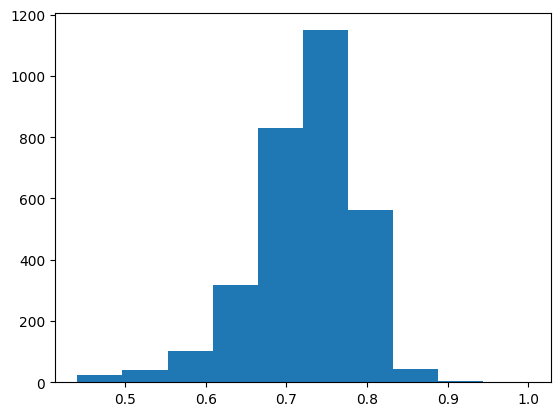

In [43]:
plt.hist(hate_results_yes['hate_sims'], bins=10, range=(min(hate_results['hate_sims'].values), 1))

(array([ 31.,  25., 161., 361., 634., 610., 135.,  12.,   0.,   0.]),
 array([0.44101015, 0.49690914, 0.55280812, 0.60870711, 0.66460609,
        0.72050508, 0.77640406, 0.83230305, 0.88820203, 0.94410102,
        1.        ]),
 <BarContainer object of 10 artists>)

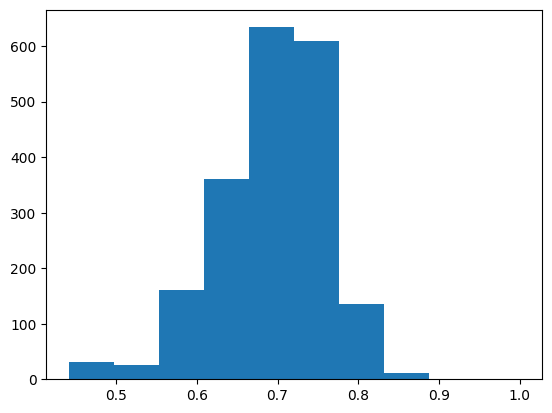

In [139]:
plt.hist(hate_results_no['hate_sims'], bins=10, range=(min(hate_results['hate_sims'].values), 1))

Okay, those look _very_ similar, but it looks like there is a slight difference present. Let's run a t-test to see if the "yes" group has higher similarities than the "no" group.

In [44]:
np.mean(hate_results_yes['hate_sims']), np.mean(hate_results_no['hate_sims'])

(0.7231267624792403, 0.6937251291566259)

In [45]:
import scipy.stats as sts

sts.ttest_ind(hate_results_yes['hate_sims'], hate_results_no['hate_sims'], equal_var=False)

TtestResult(statistic=15.34358895314656, pvalue=1.0479532880093838e-51, df=4093.3348136883433)

Aaaand with 1.047e-51 as a value, it feels safe to say they do. Additionally, we can look at a few of the values labeled as "no".

In [142]:
hate_results[hate_results['gpt_int'] == 0].sample(10)['clean_content'].values

array(['\r\nwoah... take your shots aiden',
       "\r\n>No it isn't me idk what to tell you but you seem mad at someone, out of some kind of insecurity or something???Yeah, i'm insecure, i hate it so much...>Why do you hate this person so much?I love him desu, he is so cute and good looking Ahhh, but he is retarded and ik he is old now...it's a shame tho>You are unhinged and need help:/Yes >Also yeah there was a tranny emperor lolNONO NEVERYou only use shitty bias sources from his political opponents, please shut the fuck up",
       '\r\n>-16/+6ehhhh creepy moid kinda cringe',
       "\r\nSomething I always think about when I consider suicide is either doing something that is functionally suicide but could be a sort of reset on life, like literally just packing up some basic shit and leaving without telling anyone, railway hobo type shit, or thinking about what I could do that'd be 'useful' with my suicide like trying to think of evil people I could attempt to track down and kill bef

Not all of these feel mislabeled, but oddly many do. "Holy cope" is a common response to make fun of someone, and the second post asks that someone "please shut the fuck uip", which also feels like a mislabel. 

In [48]:
vcs = hate_results[['Topic1', 'gpt_int']].groupby('Topic1').value_counts()
vcs

Topic1  gpt_int
6       1          3031
        0          1833
42      0             7
        1             5
99      0            86
        1            31
Name: count, dtype: int64

We now turn our attention to the prevelance of different discourse atoms.

In [85]:

HRT_TOPICS = [4, 23, 48, 52]
VT_TOPICS = [44, 54]
BODY_TOPICS = [19, 5]
TRANSITION_UNDERSTANDING = [43, 83, 62]
BIOLOGY_UNDERSTANDING = [76, 27, 57]
STM_TOPICS = HRT_TOPICS + VT_TOPICS + BODY_TOPICS + TRANSITION_UNDERSTANDING + BIOLOGY_UNDERSTANDING

TROLLING = [99, 6]
FETISH = [42]
HATE_POST_TOPICS = TROLLING + FETISH

topics_by_author = corpus_topics.copy()[['author', 'Topic1']]

topics_by_author['HRT'] = topics_by_author['Topic1'].apply(lambda x: x in HRT_TOPICS)
topics_by_author['VT'] = topics_by_author['Topic1'].apply(lambda x: x in VT_TOPICS)
topics_by_author['BODY'] = topics_by_author['Topic1'].apply(lambda x: x in BODY_TOPICS)
topics_by_author['TRANSITION'] = topics_by_author['Topic1'].apply(lambda x: x in TRANSITION_UNDERSTANDING)
topics_by_author['BIOLOGY'] = topics_by_author['Topic1'].apply(lambda x: x in BIOLOGY_UNDERSTANDING)
topics_by_author['STM'] = topics_by_author['Topic1'].apply(lambda x: x in STM_TOPICS)
topics_by_author['TROLLING'] = topics_by_author['Topic1'].apply(lambda x: x in TROLLING)
topics_by_author['FETISH'] = topics_by_author['Topic1'].apply(lambda x: x in FETISH)
topics_by_author['HATE'] = topics_by_author['Topic1'].apply(lambda x: x in HATE_POST_TOPICS)

tripcodes = topics_by_author[topics_by_author['author'].values != 'Anonymous']
nontripcodes = topics_by_author[topics_by_author['author'].values == 'Anonymous']

print('----------Tripcodes---------\n', tripcodes.drop(['author', 'Topic1'], axis=1).sum())
print('-------------Non Tripcodes------------\n', nontripcodes.drop(['author', 'Topic1'], axis=1).sum())

#print('----------Tripcodes---------\n', 100 * tripcodes.drop(['author', 'Topic1'], axis=1).sum() / len(tripcodes))
#print('-------------Non Tripcodes------------\n', 100 * nontripcodes.drop(['author', 'Topic1'], axis=1).sum() / len(nontripcodes))


----------Tripcodes---------
 HRT           242
VT             60
BODY          264
TRANSITION    113
BIOLOGY        16
STM           695
TROLLING      547
FETISH          3
HATE          550
dtype: int64
-------------Non Tripcodes------------
 HRT           2108
VT             406
BODY          2273
TRANSITION    1534
BIOLOGY        312
STM           6633
TROLLING      5640
FETISH          15
HATE          5655
dtype: int64


In [283]:
corpus_topics['Topic1'] = corpus_topics['Topic1'].apply(lambda x: labels[x] if x != -1 else -1)
corpus_topics['Topic2'] = corpus_topics['Topic2'].apply(lambda x: labels[x] if x != -1 else -1)
corpus_topics['Topic3'] = corpus_topics['Topic3'].apply(lambda x: labels[x] if x != -1 else -1)

In [284]:
all_topic_counts = count_topics(corpus_topics)
all_topic_counts_t = sorted(all_topic_counts.items(), key=lambda x: x[1], reverse=True) 

tripcode_topic_counts = count_topics(corpus_topics[has_non_anon_author])
tripcode_topic_counts_t = sorted(tripcode_topic_counts.items(), key=lambda x: x[1], reverse=True)

anon_topic_counts = count_topics(corpus_topics[~has_non_anon_author])
anon_topic_counts_t = sorted(anon_topic_counts.items(), key=lambda x: x[1], reverse=True)


In [285]:
all_topic_counts_t[:10]

[('mental support discussion', 24928),
 ('norms discussion and awareness of norms', 8526),
 ('fetishizing discussion about trans people', 6949),
 ('low self esteem', 6768),
 ('domination kink discussion?', 6649),
 ('gender philosophy', 4727),
 ('body dysphoria dooming', 4684),
 ('fetish/sexual desire discussion', 4261),
 ('trans discussion, emphasis on passing', 3547),
 ('calling people incels/not masculine enough', 3471)]

In [286]:
tripcode_topic_counts_t[:10]

[('mental support discussion', 2801),
 ('norms discussion and awareness of norms', 775),
 ('low self esteem', 729),
 ('fetishizing discussion about trans people', 639),
 ('domination kink discussion?', 633),
 ('body dysphoria dooming', 511),
 ('gender philosophy', 404),
 ('advise against things or supression', 344),
 ('bone shape discussion', 296),
 ('fetish/sexual desire discussion', 295)]

In [287]:
anon_topic_counts_t[:10]

[('mental support discussion', 22127),
 ('norms discussion and awareness of norms', 7751),
 ('fetishizing discussion about trans people', 6310),
 ('low self esteem', 6039),
 ('domination kink discussion?', 6016),
 ('gender philosophy', 4323),
 ('body dysphoria dooming', 4173),
 ('fetish/sexual desire discussion', 3966),
 ('trans discussion, emphasis on passing', 3297),
 ('calling people incels/not masculine enough', 3231)]

Mental support discussion seems incredibly prevelant. Let's look at the posts closest to it, and recall that it is DA number 31.


In [277]:
print("Discourse_Atom " + str(31) + f' dubbed {labels[31]}')
print([i[0] for i in w2v.wv.similar_by_vector(dictionary[31],topn=25)]) #what are the most similar words to the Nth
for num, j in enumerate(exemplar_posts[31]):
    print(f'Examplar {num}:')
    pprint.pprint(corpus_reset['content'].values[j]) # what is the most similar document to this atom?
print('==============================\n')

Discourse_Atom 31 dubbed mental support discussion
['lass', 'itbut', 'bonkers', 'comforting', 'itand', 'sus', 'inadequate', 'likei', 'overthinking', 'anywayi', 'huh', 'lmaoi', 'dw', 'optimistic', 'idki', 'dolled', 'reveal', 'reassurance', 'ghosting', 'transi', 'stuffbut', 'apologize', 'roping', 'bud', 'grateful']
Examplar 0:
('>>34788903kek reminds me of some of neros really old stuff '
 'actually>>34788870ty ty i try to keep it in but i was given permission and '
 'could not help myself>>34788862comfy weekend oh manenjoy :))i may well be up '
 'for it tonight but i am being indecisive and lazy about plans rn kekso i '
 "shall play it by ear but can't lie i am buzzing to play it, it looks so "
 'fun>>34788757i feel you <3was discussing this the other day, it feels like '
 'one of the suckiest things about being a tranny is having to choose between '
 'investing into ones transition or investing into other life thingsits '
 'likealready so hard to imagine saving up for surgeries etc, an

Let's investigate a little bit further. What does the wordcloud for this look like?

(-0.5, 999.5, 999.5, -0.5)

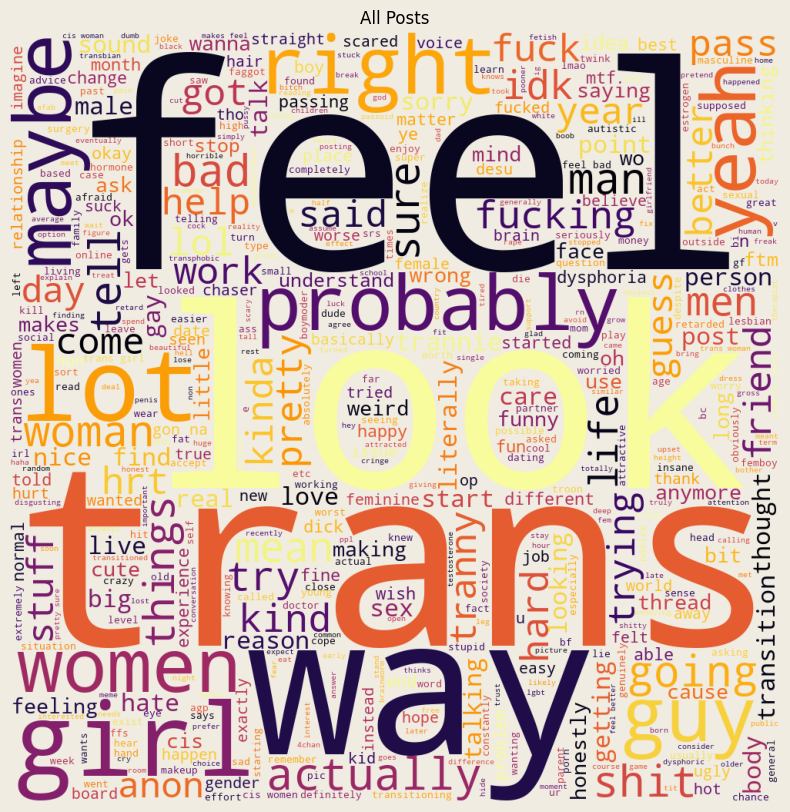

In [318]:
mental_support_inds = (corpus_topics['Topic1'] == labels[31])# | (corpus_topics['Topic2'] == labels[31]) | (corpus_topics['Topic3'] == labels[31])

mental_support_topics = corpus_topics[mental_support_inds]

all_contents = flatten(mental_support_topics['normalized_sents']\
    .apply(lambda x: flatten(x))\
    .tolist())

with open('../data/stospwords.txt') as f:
    stop_words = ast.literal_eval(f.readline())

stop_words = stop_words + ['nt', 'thing', 'tran']

all_contents = [w for w in all_contents if w not in stop_words ]

BACKGROUND_COLOR = '#F0ECE2' # soft-white

fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor(BACKGROUND_COLOR)

wc = wordcloud.WordCloud(background_color=BACKGROUND_COLOR,
                    max_words=500, width=1000, height=1000,
                    mode='RGBA', colormap='inferno')\
                    .generate(' '.join(all_contents))
ax.imshow(wc)
ax.set_title('All Posts')
ax.axis('off')

Admittedly, the below code is duct taped together, but below we replicate the dimension projection embeddings from the word embeddings notebook.

In [207]:
def normalize(vector):
    return vector / np.linalg.norm(vector)

def dimension(model, positives, negatives):
    return sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])

def makeDF(model, word_list, dimension, dimension_name):
    d = []

    for word in word_list:
        d.append(cosine_similarity(w2v.wv[word].reshape(1,-1), dimension.reshape(1,-1))[0][0])
    df = pd.DataFrame({dimension_name: d}, index = word_list)
    return df

def makeDFfromDocList(docs, dimension, dimension_name):
    d = []
    
    for ind, doc in docs.iterrows():
        d.append(cosine_similarity(np.array(doc['docvecs']).reshape(1, -1), dimension.reshape(1, -1))[0][0])
    df = pd.DataFrame({dimension_name: d}, index=docs['id'])
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    
    return c

def coloring_and_jitter(ids, reference_df):
    '''
    Mildly cursed function which returns both 
    '''
    rv, x= [], []
    refdf = reference_df.reset_index()
    for id_ in ids:
        post = refdf[refdf['id'] == id_]
        author = post['author'].values[0]

        if author == 'Anonymous':
            rv.append('Blue')
            x.append(-.1)
        else:
            rv.append('Red')
            x.append(.1)
    return rv, x

def PlotDimension(ax, df, dim, reference_df):
    
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors, x = coloring_and_jitter(df['id'], reference_df)
    for i, word in enumerate(df.index):
        ax.plot(x[i], df[dim][i], 'o', color = colors[i], alpha = 0.005)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

cis_trans = dimension(w2v.wv, ['trans', 'tran', 'mtf', 'ftm'], ['cis', 'cisgender', 'cism', 'cisf'])

euphoria_dysphoria = dimension(w2v.wv, ['euphoria'], ['dysphoria'])

In [149]:
euphoria_dim = makeDFfromDocList(corpus, euphoria_dysphoria, 'euphoria')

In [195]:
euphoria_dim.head()

,euphoria
id,
34548229,0.281733
34548373,0.242518
34548423,0.281837
34548609,-0.005078
34548655,0.313261


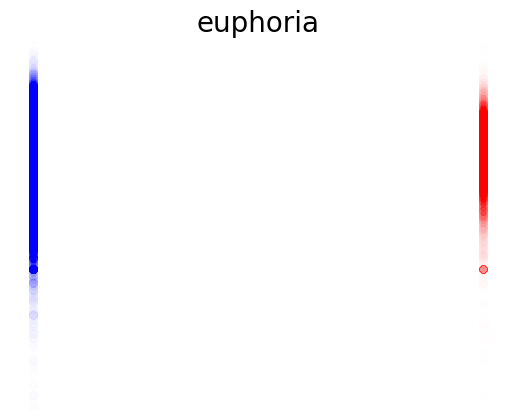

In [208]:
fig, ax = plt.subplots()
PlotDimension(ax, euphoria_dim.reset_index(), 'euphoria', corpus)